# Alameda Autocorrelation analysis

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import libpysal as lps
import esda
import pysal

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Notebook setup

In [3]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'
# save to local?
save_local = True
# use local data?
local_data = False
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [14]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution
res = 9
# Area of analysis
area_of_analysis = 'hexagonos' # zona_censal, hexagonos, unidades_vecinales
# Persona speed
walk_speed = 4.5
speed_name = str(walk_speed).replace('.','_')

In [15]:
schema = 'projects_research'

if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

## Read data

In [16]:
if area_of_analysis == 'zona_censal' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_zonascensalesanalysis_{speed_name}_kmh.geojson')

elif area_of_analysis == 'zona_censal' and not local_data:
    table = f'santiago_zonascensalesanalysis_{speed_name}_kmh'
    schema = 'projects_research'
    gdf = aup.gdf_from_db(table, schema)

elif area_of_analysis == 'unidades_vecinales' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_unidadesvecinales_hqsl_{speed_name}_kmh.gpkg')

elif area_of_analysis == 'unidades_vecinales' and not local_data:
    table = f'santiago_unidadesvecinalesanalysis_{speed_name}_kmh'
    schema = 'projects_research'
    gdf = aup.gdf_from_db(table, schema)

elif area_of_analysis == 'hexagonos' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_hexanalysis_res{res}_{speed_name}_kmh.geojson')

elif area_of_analysis == 'hexagonos' and not local_data:
    query = f'SELECT * FROM {schema}.santiago_hexanalysis_{speed_name}_kmh WHERE res = {res}'
    gdf = aup.gdf_from_query(query)

print(gdf.shape)
gdf.head(2)

(9080, 31)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,hex_id,geometry,supplying,caring,living,enjoying,learning,working,hqsl,res
0,0.0,0.0,2.0,0.116099,0.000000,0.000000,2.116099,0.401235,0.0,3.333333,...,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",0.133745,0.903161,2.222222,0.358975,0.000000,0.003983,3.622086,9
1,0.0,0.0,0.0,1.888014,0.166667,0.046296,2.100977,0.000000,0.0,0.000000,...,89b2c509dc7ffff,"POLYGON ((-70.53795 -33.53054, -70.53912 -33.5...",0.000000,0.708336,0.000000,1.788012,0.092593,0.106960,2.695900,9


### Filter data

In [7]:
filter_data = False

In [8]:
if filter_data:
    
    alameda = gpd.read_file(grl_dir + 'zonas_censales_buffer800m_alameda.gpkg')
    hex_id_list = list(gpd.clip(gdf, alameda).hex_id.unique())
    gdf = gdf.loc[gdf.hex_id.isin(hex_id_list)]
print(gdf.shape)
gdf.head(2)

(58695, 31)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,hex_id,geometry,supplying,caring,living,enjoying,learning,working,hqsl,res
0,5.833333,5.833333,5.000000,5.638199,7.500000,4.166667,33.971533,4.583333,1.875000,0.543189,...,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",5.879630,5.257120,3.597730,4.894993,5.833333,4.943534,30.406339,10
1,1.250000,0.520833,3.041667,1.798392,1.166667,1.805556,9.583114,1.875000,1.666667,0.000000,...,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",1.458333,1.864732,1.689815,1.489474,2.523148,1.620370,10.645872,10


<AxesSubplot: >

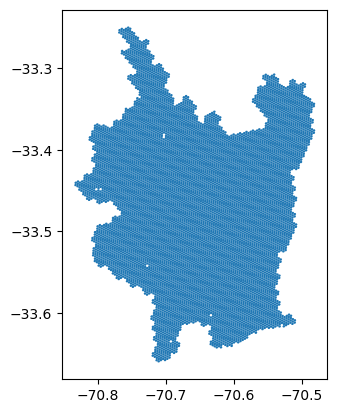

In [17]:
gdf.plot()

## Data distribution

In [18]:
import seaborn as sns

In [19]:
# hqsl, supplying, working, learning, caring, enjoying, living
column_analysis = 'learning'

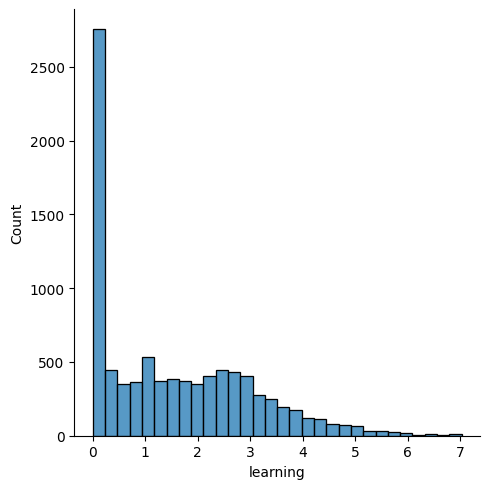

In [20]:
sns.displot(gdf, x=column_analysis)

## Spatial data analysis

### LISA function

In [21]:
def lisa_fn(gdf, column_analysis):
    wq = create_weights_queen_matrix(gdf)
    df = calculate_lag(gdf, wq, column_analysis)
    df = calculate_lisa(gdf, column_analysis)
    
    return df

def create_weights_queen_matrix(gdf):
    df = gdf.copy()
    wq =  lps.weights.Queen.from_dataframe(df)
    wq.transform = 'r'
    return wq

def calculate_lag(gdf, wq, column_analysis):
    df = gdf.copy()
    y = df[column_analysis]
    ylag = lps.weights.lag_spatial(wq, y)
    df[f'lag_{column_analysis}'] = ylag
    return df

def calculate_lisa(gdf, column_analysis):
    df = gdf.copy()
    y = df[column_analysis]
    
    wq = lps.weights.distance.Kernel.from_dataframe(df[[column_analysis,'geometry']])
    li = esda.moran.Moran_Local(y, wq)
    
    sig = 1 * (li.p_sim < 0.05)
    hotspot = 1 * (sig * li.q==1)
    coldspot = 3 * (sig * li.q==3)
    doughnut = 2 * (sig * li.q==2)
    diamond = 4 * (sig * li.q==4)
    spots = hotspot + coldspot + doughnut + diamond

    spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
    labels = [spot_labels[i] for i in spots]

    df[f'hotspot_{column_analysis}'] = labels
    
    
    return df

In [22]:
# hqsl, supplying, working, learning, caring, enjoying, living, environmental_impact, supplying, wellbeing
cols_analysis = ['hqsl', 'supplying', 'working', 'learning', 
                'caring', 'enjoying', 'living', 'environmental_impact', 
                'sociability', 'wellbeing']

for column_analysis in cols_analysis:
    
    df_tmp = lisa_fn(gdf, column_analysis)
    df_tmp = df_tmp[['hex_id',f'hotspot_{column_analysis}']].copy()
    gdf = gdf.merge(df_tmp, on='hex_id')

print(gdf.shape)
gdf.head(5)

(9080, 41)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,hotspot_hqsl,hotspot_supplying,hotspot_working,hotspot_learning,hotspot_caring,hotspot_enjoying,hotspot_living,hotspot_environmental_impact,hotspot_sociability,hotspot_wellbeing
0,0.000000,0.000000,2.0,0.116099,0.000000,0.000000,2.116099,0.401235,0.000000,3.333333,...,3 cold spot,3 cold spot,3 cold spot,3 cold spot,3 cold spot,3 cold spot,0 ns,3 cold spot,3 cold spot,3 cold spot
1,0.000000,0.000000,0.0,1.888014,0.166667,0.046296,2.100977,0.000000,0.000000,0.000000,...,3 cold spot,3 cold spot,3 cold spot,3 cold spot,3 cold spot,3 cold spot,3 cold spot,3 cold spot,3 cold spot,3 cold spot
2,2.571078,0.473346,2.0,3.470122,1.411765,3.333333,13.259644,1.053922,0.514706,3.333333,...,0 ns,0 ns,0 ns,0 ns,0 ns,1 hot spot,0 ns,1 hot spot,0 ns,0 ns
3,1.324074,0.318287,0.0,0.923425,0.490741,2.844650,5.901178,1.219136,1.319444,4.151945,...,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns
4,0.081395,0.312500,0.0,0.895874,0.604651,2.787929,4.682350,1.240310,2.558140,3.333333,...,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns,0 ns


In [23]:
gdf['hotspot_count']=(gdf=='1 hot spot').sum(axis=1)

<AxesSubplot: >

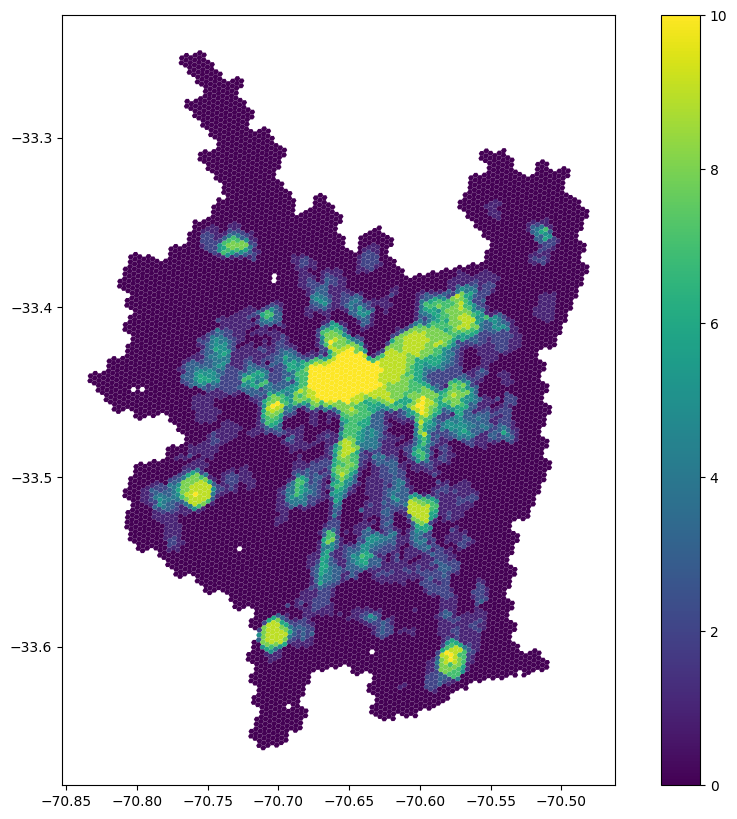

In [24]:

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})

gdf.plot(column='hotspot_count', linewidth=0.4, ax=ax, legend=True)

<AxesSubplot: >

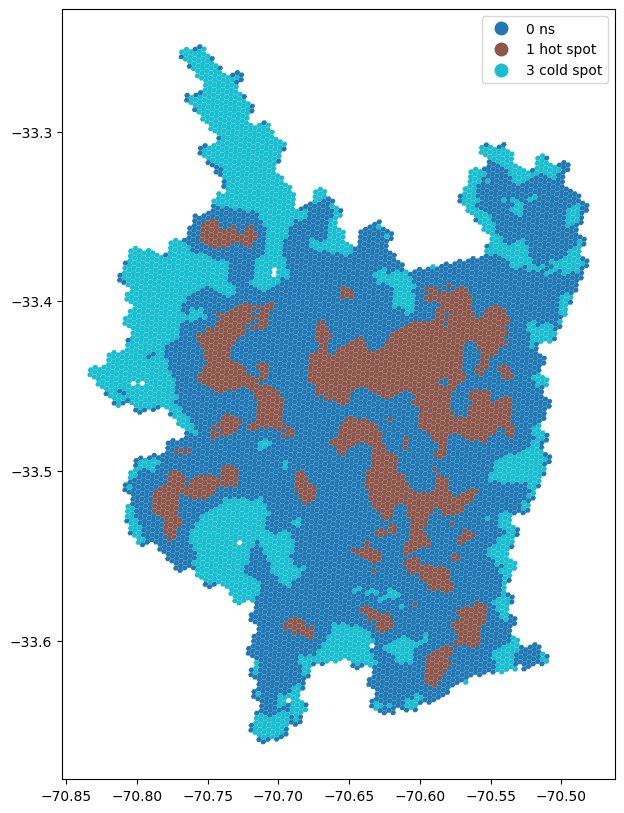

In [26]:
variable_analysis = 'environmental_impact'
column_analysis = f'hotspot_{variable_analysis}'

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})

gdf.plot(column=column_analysis, linewidth=0.4, ax=ax, legend=True)

## Save data

In [27]:
column_filter = ['hex_id','geometry']

for c in gdf.columns:
    if 'hotspot' in c:
        column_filter.append(c)

gdf_save = gdf[column_filter].copy()
        

In [28]:
gdf_save.to_file(f'../../../data/processed/santiago/santiago_hexanalysis_res{res}_hotspot.geojson')